In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://predskin.labmol.com.br/static/images/predskin-logo.png")

In [33]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
from rdkit import Chem
from rdkit.Chem.Descriptors import MolLogP
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import Descriptors
import sys
import multiprocessing
from standardiser import break_bonds, neutralise, rules, unsalt
from standardiser.utils import StandardiseException, sanity_check
%reload_ext autoreload
%autoreload 2
def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import sys
sys.path.append("../../")
from tools import tools
from tools import  pipeline as p
from tools import  sar
from sklearn.metrics import cohen_kappa_score
import csv
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import ShuffleSplit
import _pickle as cPickle
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit    
import bz2
from glob import glob
import _pickle as cPickle
import pickle
from keras.models import model_from_json
from sklearn.externals import joblib
from joblib import dump, load
# The next two lines are for optical reasons only. They can be safely disabled.
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18
#Modeling tools
exec(open('tools/modeling.py').read())

In [34]:
#Caminho do SDF
file= "data/Human_SS_curated_138.sdf"
#file= "data/LLNA_SS_curated_1004.sdf"

sdfInfo = dict(smilesName='SMILES',molColName='ROMol')
moldf = PandasTools.LoadSDF(file,**sdfInfo)
print(moldf.shape)
#Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
#duplicatas by smiles
moldf = moldf.drop_duplicates(subset=['SMILES'])
#logP
moldf['logP'] = moldf['Mol'].apply(MolLogP)
#Remove moléculas sem esrtutura no RDKit
moldf = moldf[pd.notnull(moldf['Mol'])]
print(moldf.shape)
#Colunas no pandas
#moldf.keys()

(138, 8)
(138, 9)


{'Non-sensitizer': 0, 'Sensitizer': 1}

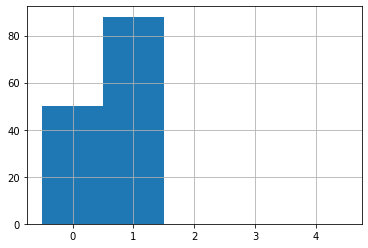

In [35]:
moldf = moldf.rename(columns={'Human result': 'Outcome'})
len(moldf[moldf.Outcome=="Non-sensitizer"])
moldf2= moldf.sort_values(['Outcome'], ascending=True)
S = moldf2['Outcome']
info = {}
for i,cls in enumerate(S.unique()):
    info.update({cls:i})
    S = S.replace(cls,i)
ax = S.hist(bins=np.arange(-0.5,5))
ax.set_xticks(range(0,5))
info    

In [36]:
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import Descriptors
nBits = 2 * 1024
radius=6
calcfp = lambda mol: GetMorganFingerprintAsBitVect(mol,nBits=nBits,radius=radius, useFeatures=False)

moldf['Descriptors'] = moldf.Mol.apply(calcfp)

y_raw_one= np.unique(moldf['Outcome'], return_inverse=True)
y_raw_one=y_raw_one=y_raw_one[1]
X_raw = np.array(list(moldf['Descriptors']))

from keras.utils import to_categorical
import numpy as np

unique_labels, new_labels = np.unique(moldf['Outcome'], return_inverse=True)
y_raw =to_categorical(new_labels, num_classes=None)
moldf=moldf[['Compound name','CASRN','Outcome', 'SMILES','Mol','logP']]

In [37]:
#Loading multiple models
graph1 = tf.Graph()
with graph1.as_default():
    session1 = tf.compat.v1.Session()
    with session1.as_default():
        with open('model/dpra.json') as arch_file:
            model1 = model_from_json(arch_file.read())
        model1.load_weights('model/dpra.h5')

graph2 = tf.Graph()
with graph2.as_default():
    session2 = tf.compat.v1.Session()
    with session2.as_default():
        with open('model/KeratinoSens.json') as arch_file:
            model2 = model_from_json(arch_file.read())
        model2.load_weights('model/KeratinoSens.h5')
        
graph3 = tf.Graph()
with graph3.as_default():
    session3 = tf.compat.v1.Session()
    with session3.as_default():
        with open('model/hclat.json') as arch_file:
            model3 = model_from_json(arch_file.read())
        model3.load_weights('model/hclat.h5')
        
graph4 = tf.Graph()
with graph4.as_default():
    session4 = tf.compat.v1.Session()
    with session4.as_default():
        with open('model/llna.json') as arch_file:
            model4 = model_from_json(arch_file.read())
        model4.load_weights('model/llna.h5')  
        
        
graph5 = tf.Graph()
with graph5.as_default():
    session5 = tf.compat.v1.Session()
    with session5.as_default():
        with open('model/human.json') as arch_file:
            model5 = model_from_json(arch_file.read())
        model5.load_weights('model/human.h5')         

## 1. DPRA

In [38]:
with graph1.as_default():
     with session1.as_default():
            moldf['DPRA Pred']=model1.predict_classes(X_raw)

## 2. KeratinoSens

In [39]:
with graph2.as_default():
     with session2.as_default():
            moldf['KeratinoSens Pred']=model2.predict_classes(X_raw)        

## 3. h-CLAT

In [40]:
#Caminho do SDF
file= "data/Human_SS_curated_138.sdf"
#file= "data/LLNA_SS_curated_1004.sdf"
sdfInfo = dict(smilesName='SMILES',molColName='ROMol')
moldf2 = PandasTools.LoadSDF(file,**sdfInfo)
print(moldf2.shape)
#Rename ROMol
moldf2 = moldf2.rename(columns={'ROMol': 'Mol'})
#duplicatas by smiles
moldf2 = moldf2.drop_duplicates(subset=['SMILES'])
#logP
moldf2['logP'] = moldf2['Mol'].apply(MolLogP)
#Remove moléculas sem esrtutura no RDKit
moldf2 = moldf2[pd.notnull(moldf2['Mol'])]
print(moldf2.shape)
#Colunas no pandas
moldf2.keys()
moldf2 = moldf2.rename(columns={'Human result': 'Outcome'})
calcfp = lambda mol: MACCSkeys.GenMACCSKeys(mol)
moldf2['Descriptors'] = moldf2.Mol.apply(calcfp)
X_raw_maccs = np.array(list(moldf2['Descriptors']))
y_raw_one_maccs= np.unique(moldf2['Outcome'], return_inverse=True)
y_raw_one_maccs=y_raw_one=y_raw_one_maccs[1]
with graph3.as_default():
     with session3.as_default():
            moldf['h-CLAT Pred']=model3.predict_classes(X_raw_maccs)

(138, 8)
(138, 9)


## 4. LLNA 

In [41]:
nBits = 2 * 1024
radius=4
calcfp = lambda mol: GetMorganFingerprintAsBitVect(mol,nBits=nBits,radius=radius, useFeatures=True)
moldf2['Descriptors2'] = moldf2.Mol.apply(calcfp)
X_raw_fcfp = np.array(list(moldf2['Descriptors2']))

with graph4.as_default():
     with session4.as_default():
            moldf['LLNA Pred'] =  model4.predict_classes(X_raw_fcfp)        

 ## 5. Human

In [42]:
with graph5.as_default():
     with session5.as_default():
            moldf['Human Pred'] =  model5.predict_classes(X_raw)

 ## 5. Bayesian Model

In [43]:
X_bayes= np.array(moldf.iloc[:, 10:15])
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bayes, y_raw_one, test_size=0.2, random_state=43)
gnb = GaussianNB()
y_pred = gnb.fit(X_bayes, y_raw_one).predict(X_bayes)
print("Number of mislabeled points out of a total %d points : %d"
       % (X_bayes.shape[0], (y_raw_one != y_pred).sum()))

Number of mislabeled points out of a total 138 points : 6


 ### 5.1 Bayesian Model - Statistics

Number of mislabeled points out of a total 28 points : 2


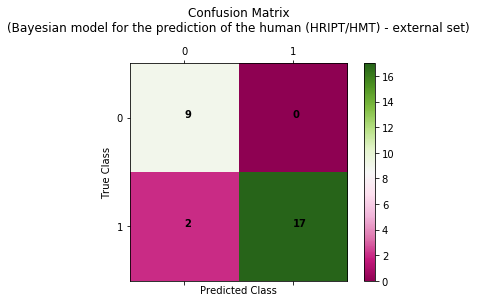

########################################
#   Unbalanced Statistical Parameters  #
########################################
Accuracy: 0.93
Area under the Curve (AUC): 0.95
########################################
#   Balanced Statistical Parameters    #
########################################
Correct Classification Rate (CCR): 0.94
Weighted Kappa:  0.85
########################################
#            Positive Class            #
########################################
Sensitivity (Se): 0.89
Positive Predictive Value (PPV): 1.0
########################################
#            Negative Class            #
########################################
Specificity (Sp): 1.0
Negative Predictive Value (NPV): 0.82
########################################
#     Other Statistical Parameters     #
########################################
Precision:  1.0
Recall:  0.89
F1:  0.94
########################################
#        Applicability Domain          #
#################################

In [44]:
gnb = GaussianNB()
y_pred_test = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred_test).sum()))

CCR, kappa,sensitivity, sensitivity = run_statistics(y_test, gnb.predict(X_test), 
                                                     label="Bayesian model for the prediction of the human (HRIPT/HMT) - external set", coverage=100)

## 5.2 - principal component analysis (PCA) of the Baesian Predictions

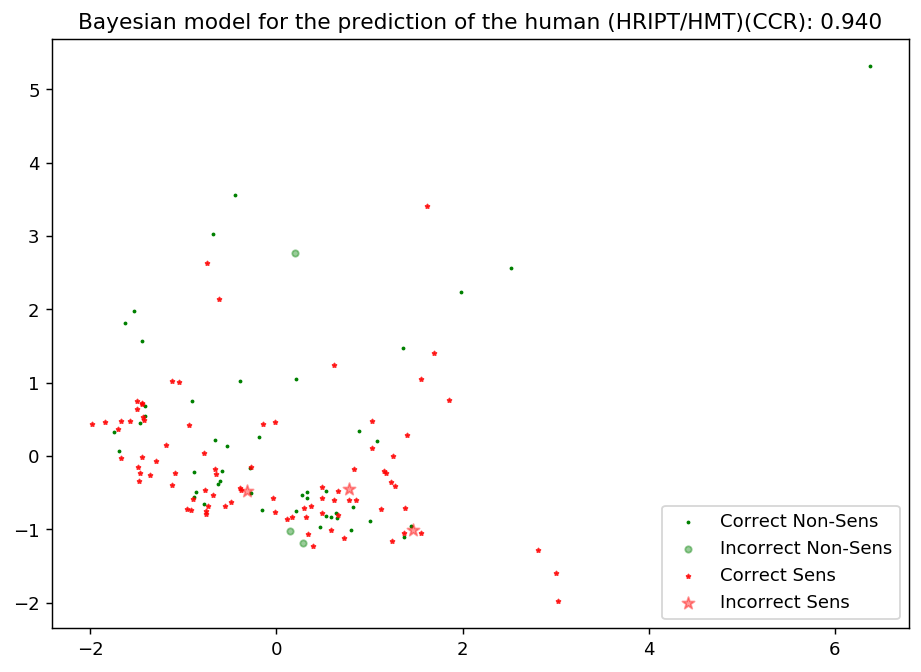

In [45]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Define our PCA transformer and fit it onto our raw dataset.
# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 231
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed = pca.fit_transform(X=X_raw)
# Isolate the data we'll need for plotting.
x_component, y_component = transformed[:, 0], transformed[:, 1]
predictions = gnb.predict(X_bayes)
is_correct = (predictions == y_raw_one)
is_correct_0 = (predictions == y_raw_one) & (y_raw_one == 0)
is_correct_1 = (predictions == y_raw_one) & (y_raw_one == 1)
predictions_0 = (predictions != y_raw_one) & (y_raw_one == 0)
predictions_1 = (predictions != y_raw_one) & (y_raw_one == 1)
# Plot our updated classification results once we've trained our learner.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
ax.scatter(x=x_component[is_correct_0],  y=y_component[is_correct_0],  c='g', marker='.', label='Correct Non-Sens', s=5, alpha=10/10)
ax.scatter(x=x_component[predictions_0], y=y_component[predictions_0], c='g', marker='.', label='Incorrect Non-Sens',s=50, alpha=4/10)
ax.scatter(x=x_component[is_correct_1],  y=y_component[is_correct_1],  c='r', marker='*', label='Correct Sens', s=5,  alpha=8/10)
ax.scatter(x=x_component[predictions_1], y=y_component[predictions_1], c='r', marker='*', label='Incorrect Sens',s=50 ,alpha=4/10)
ax.set_title('Bayesian model for the prediction of the human (HRIPT/HMT)(CCR): {final_acc:.3f}'.format( final_acc=CCR))
ax.legend(loc='lower right')
plt.show()

## Overall Predictions for all models

,Compound name,CASRN,Outcome,SMILES,Mol,logP,DPRA Pred,KeratinoSens Pred,h-CLAT Pred,LLNA Pred,Human Pred,Bayesian Pred,Preds Sum
0,"1,2-Benzisothiazolin-3-one",2634-33-5,Sensitizer,O=c1[nH]sc2ccccc12,,1.58960,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,5
1,"1,2-Dibromo-2,4-dicyanobutane",35691-65-7,Sensitizer,N#CCCC(Br)(C#N)CBr,,2.34236,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,5
2,"1,4-Dihydroquinone",123-31-9,Sensitizer,Oc1ccc(O)cc1,,1.09780,Sensitizer,Non-sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,4
3,1-Octen-3-yl acetate,2442-10-6,Sensitizer,C=CC(CCCCC)OC(C)=O,,2.68440,Sensitizer,Non-sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,4
4,"2,4-Dinitrochlorobenzene",97-00-7,Sensitizer,O=[N+]([O-])c1ccc(Cl)c([N+](=O)[O-])c1,,2.15640,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,5
5,"2,5-Toluenediamine",615-50-9,Sensitizer,Cc1cc(N)ccc1N,,1.15942,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,5
6,2-Aminophenol,95-55-6,Sensitizer,Nc1ccccc1O,,0.97440,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,5
7,2-Hexylidene cyclopentanone,17373-89-6,Sensitizer,CCCCCC=C1CCCC1=O,,3.24610,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Sensitizer,5
8,2-Hydroxyethyl acrylate,818-61-1,Sensitizer,C=CC(=O)OCCO,,-0.29210,Sensitizer,Sensitizer,Non-sensitizer,Sensitizer,Sensitizer,Sensitizer,4
9,2-Hydroxypropyl methacrylate,923-26-2,Sensitizer,C=C(C)C(=O)OCC(C)O,,0.48650,Sensitizer,Sensitizer,Non-sensitizer,Non-sensitizer,Sensitizer,Sensitizer,3

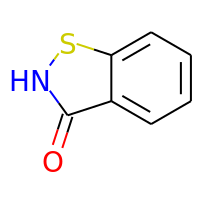
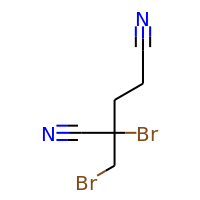
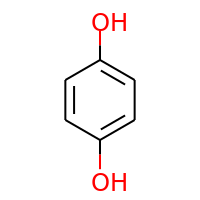
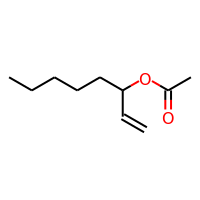
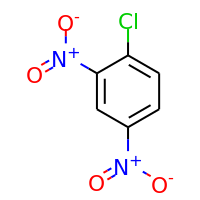
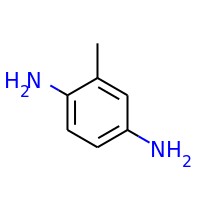
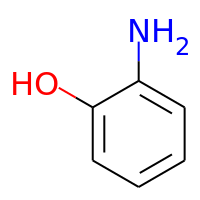
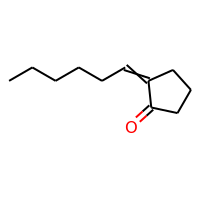
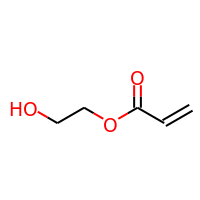
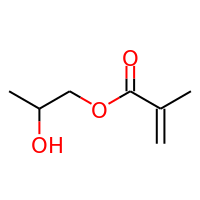
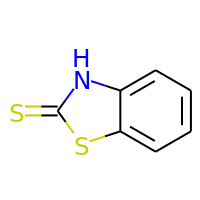
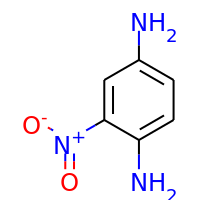
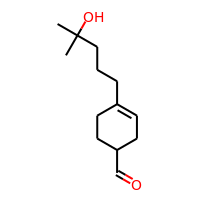
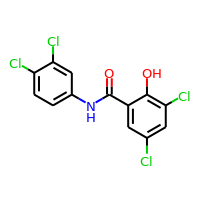
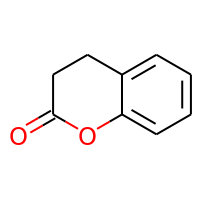
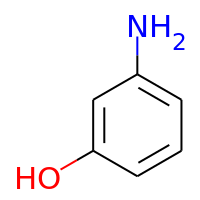
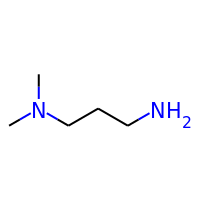
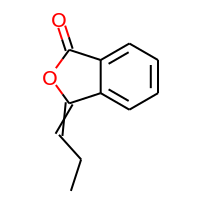
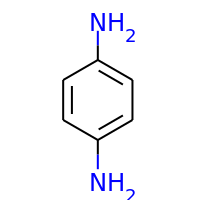
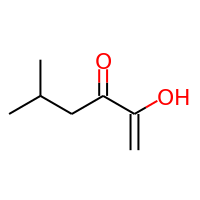
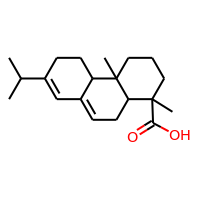
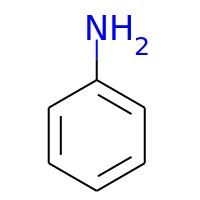
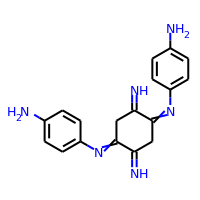
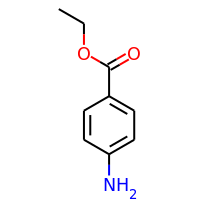
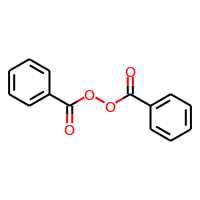
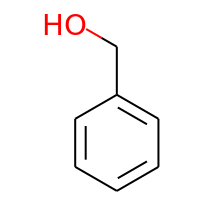
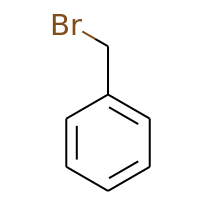
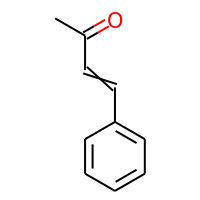
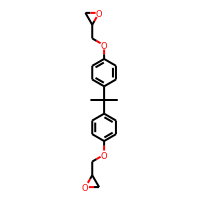
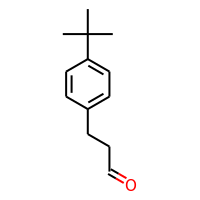
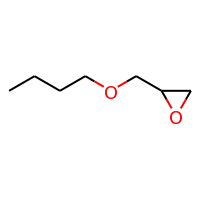
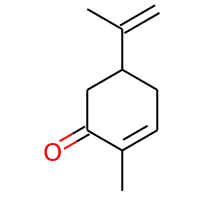
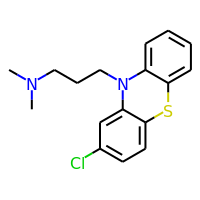
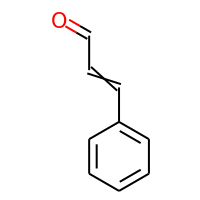
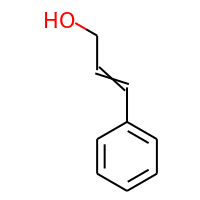
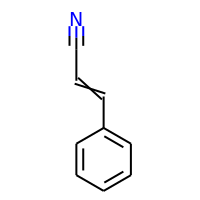
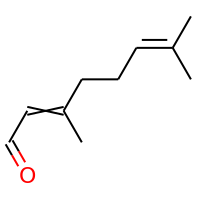
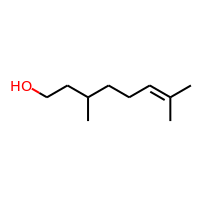
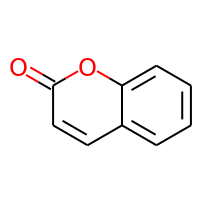
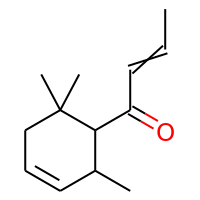
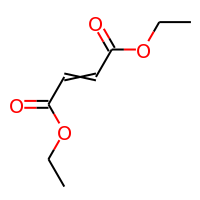
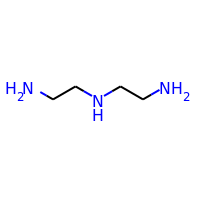
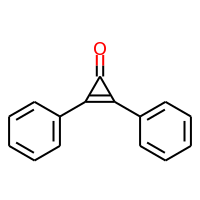
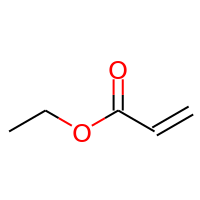
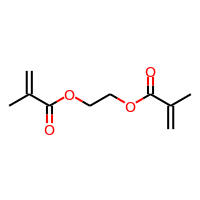
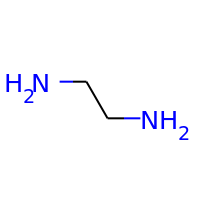
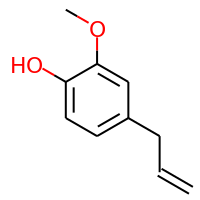
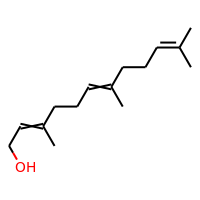
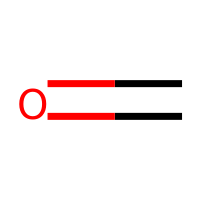
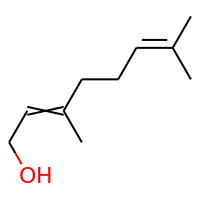
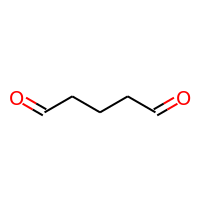
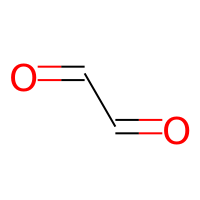
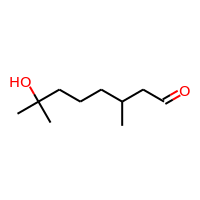
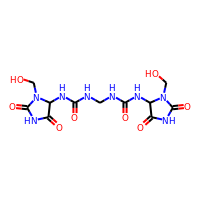
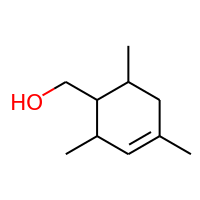
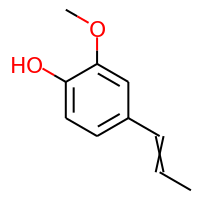
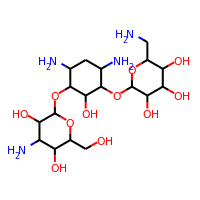
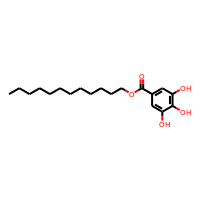
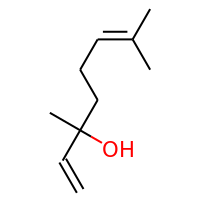
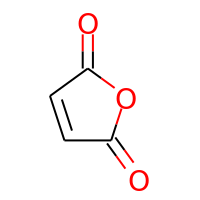
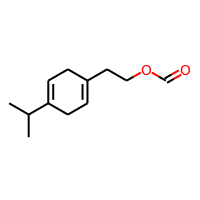
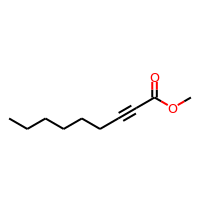
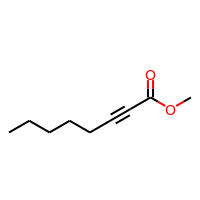
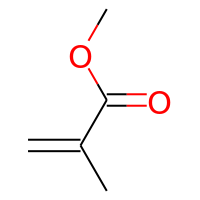
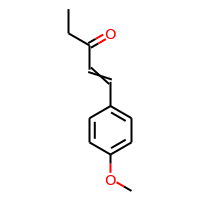
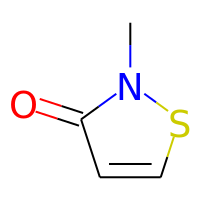
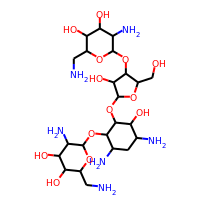
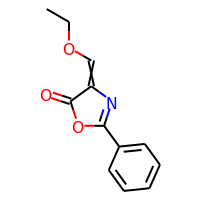
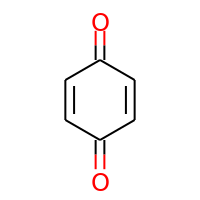
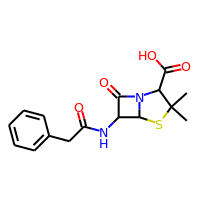
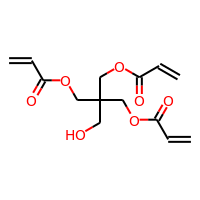
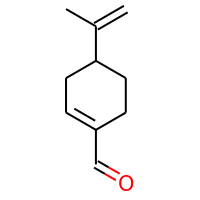
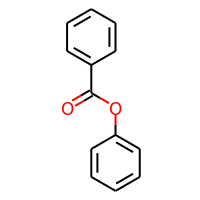
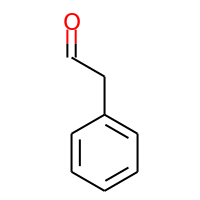
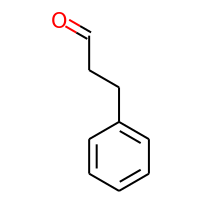
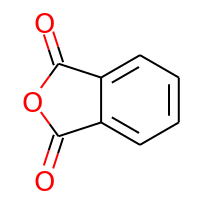
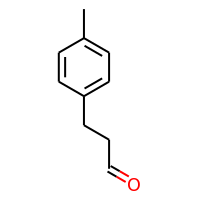
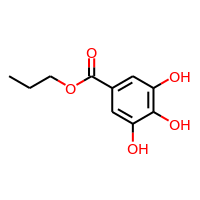
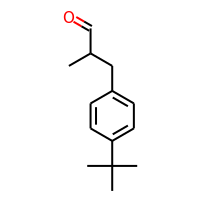
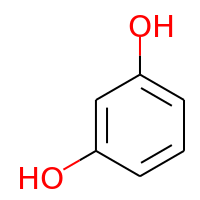
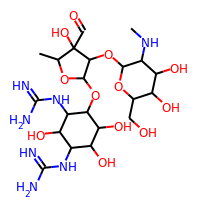
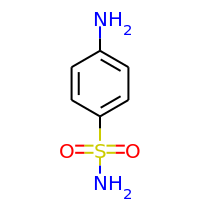
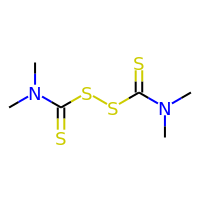
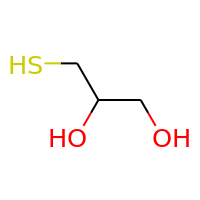
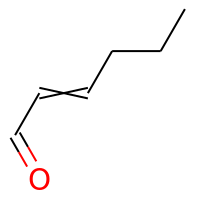
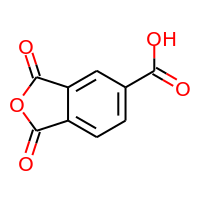
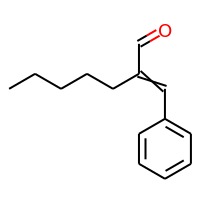
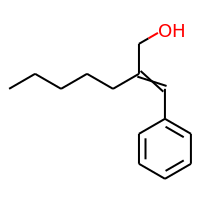
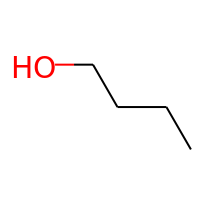
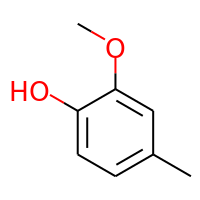
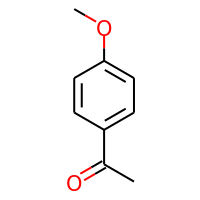
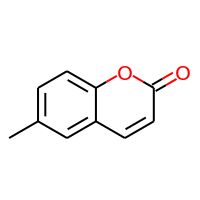
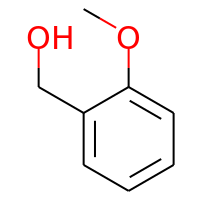
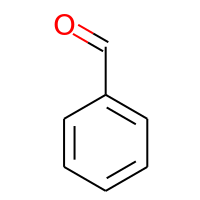
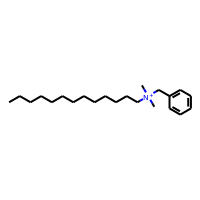
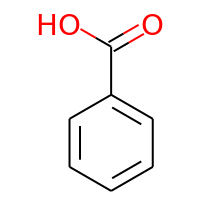
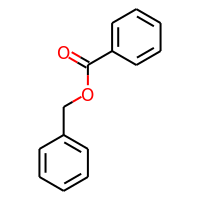
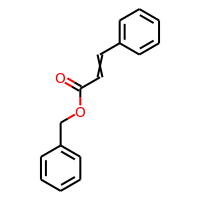
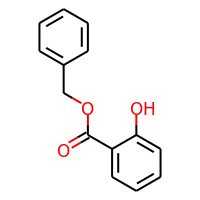
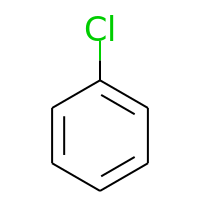
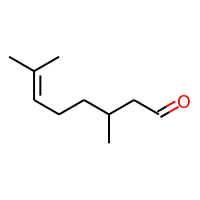
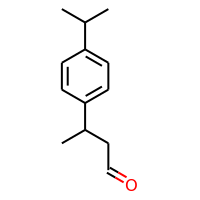
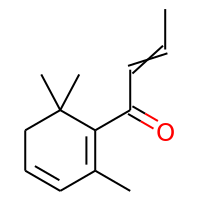
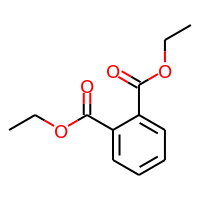
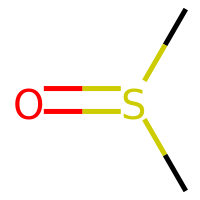
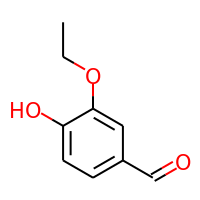
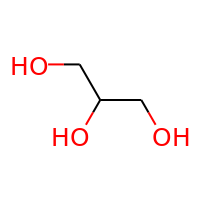
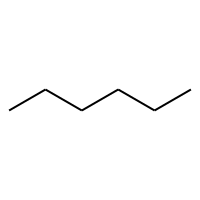
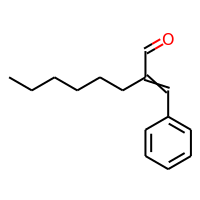
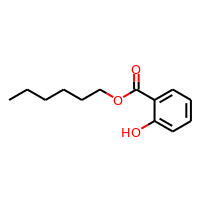
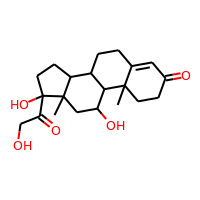
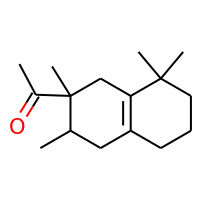
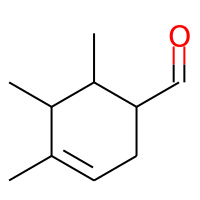
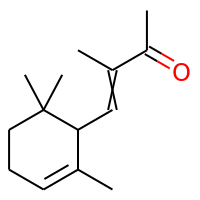
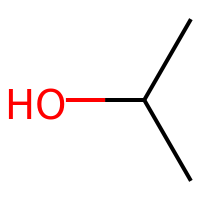
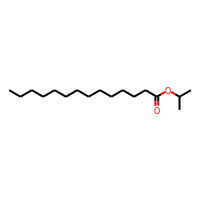
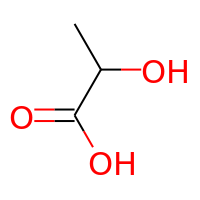
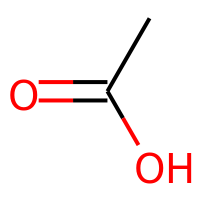
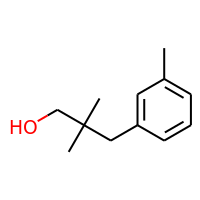
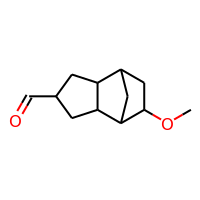
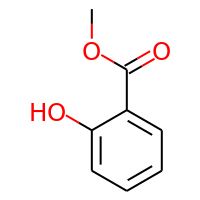
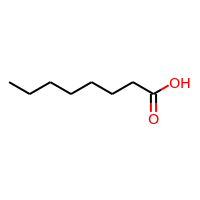
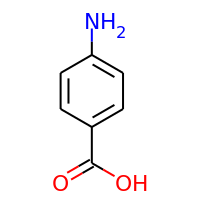
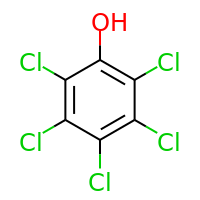
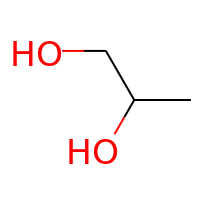
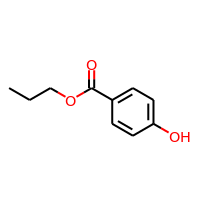
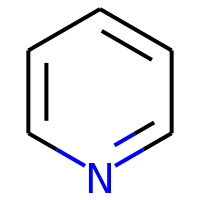
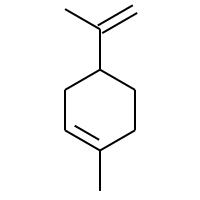
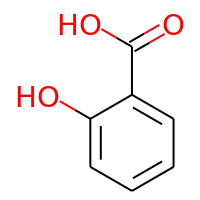
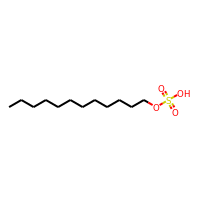
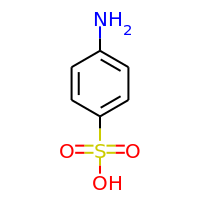
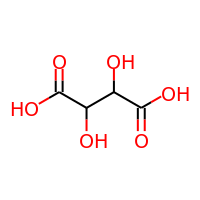
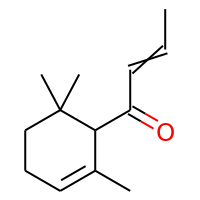
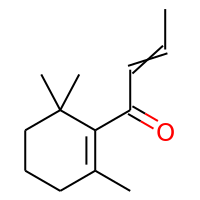
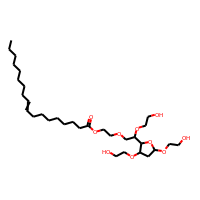
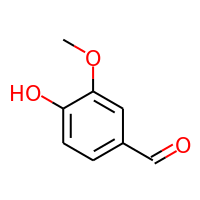
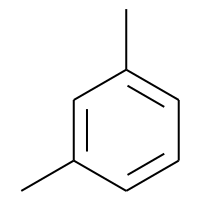
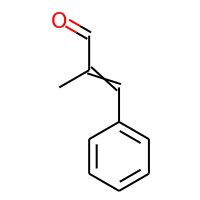

In [46]:

moldf['Bayesian Pred']= gnb.predict(X_bayes)
moldf['Preds Sum']= moldf.iloc[:, 6:11].sum(axis=1)
moldf['DPRA Pred']=np.where(moldf['DPRA Pred']>=0.6, 'Sensitizer', 'Non-sensitizer')
moldf['KeratinoSens Pred']=np.where(moldf['KeratinoSens Pred']>=0.6, 'Sensitizer', 'Non-sensitizer')
moldf['h-CLAT Pred']=np.where(moldf['h-CLAT Pred']>=0.6, 'Sensitizer', 'Non-sensitizer')
moldf['LLNA Pred']=np.where(moldf['LLNA Pred']>=0.6, 'Sensitizer', 'Non-sensitizer')
moldf['Human Pred']=np.where(moldf['Human Pred']>=0.6, 'Sensitizer', 'Non-sensitizer')
moldf['Bayesian Pred']=np.where(moldf['Bayesian Pred']>=0.6, 'Sensitizer', 'Non-sensitizer')
moldf

# Low confidence prediction for the Bayesian model means two or more individual predictions are in disagreement with Bayesian Outcome.
## Case 1
### 2 out of 5 individual model's predictions are saying Sensitizer, but the Bayesian decision is Sensitizer
 In this case, use your regulatory expertise and WoE in the human skin sensitization context.
 

2 individual model's predictions are saying Sensitizer, but the Bayesian decision is Sensitizer: 8


,Compound name,CASRN,Outcome,SMILES,Mol,logP,DPRA Pred,KeratinoSens Pred,h-CLAT Pred,LLNA Pred,Human Pred,Bayesian Pred,Preds Sum
25,Benzyl alcohol,100-51-6,Sensitizer,OCc1ccccc1,,1.17890,Non-sensitizer,Non-sensitizer,Sensitizer,Non-sensitizer,Sensitizer,Sensitizer,2
38,Coumarin,91-64-5,Sensitizer,O=c1ccc2ccccc2o1,,1.79300,Non-sensitizer,Sensitizer,Non-sensitizer,Non-sensitizer,Sensitizer,Sensitizer,2
56,Kanamycin,25389-94-0,Sensitizer,NCC1OC(OC2C(N)CC(N)C(OC3OC(CO)C(O)C(N)C3O)C2O)...,,-7.29140,Sensitizer,Non-sensitizer,Non-sensitizer,Non-sensitizer,Sensitizer,Sensitizer,2
58,Linalool,78-70-6,Sensitizer,C=CC(C)(O)CCC=C(C)C,,2.66980,Non-sensitizer,Non-sensitizer,Sensitizer,Non-sensitizer,Sensitizer,Sensitizer,2
66,Neomycin,1405-10-3,Sensitizer,NCC1OC(OC2C(CO)OC(OC3C(O)C(N)CC(N)C3OC3OC(CN)C...,,-8.89530,Non-sensitizer,Non-sensitizer,Non-sensitizer,Non-sensitizer,Sensitizer,Sensitizer,1
80,Streptomycin,3810-74-0,Sensitizer,CNC1C(OC2C(OC3C(O)C(O)C(NC(=N)N)C(O)C3NC(=N)N)...,,-7.74176,Non-sensitizer,Non-sensitizer,Non-sensitizer,Non-sensitizer,Sensitizer,Sensitizer,1
81,Sulfanilamide,63-74-1,Sensitizer,Nc1ccc(S(N)(=O)=O)cc1,,-0.08380,Non-sensitizer,Non-sensitizer,Sensitizer,Non-sensitizer,Sensitizer,Sensitizer,2
83,Thioglycerol,96-27-5,Sensitizer,OCC(O)CS,,-0.73060,Non-sensitizer,Non-sensitizer,Non-sensitizer,Sensitizer,Sensitizer,Sensitizer,2

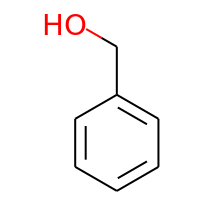
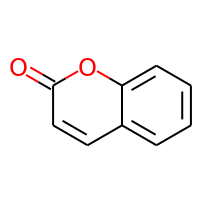
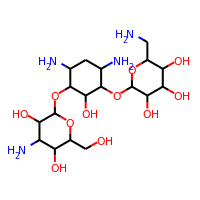
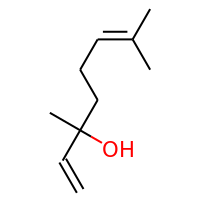
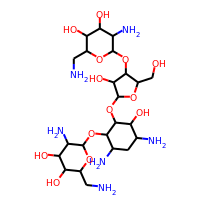
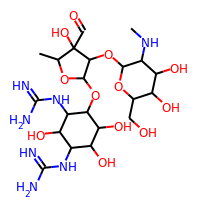
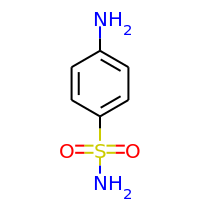
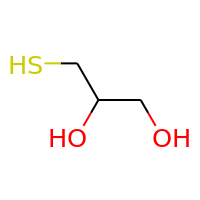

In [47]:
print ("2 individual model's predictions are saying Sensitizer, but the Bayesian decision is Sensitizer:",
       sum((moldf['Preds Sum'] <= 2) & (moldf['Bayesian Pred']== 'Sensitizer' )))
moldf[(moldf['Preds Sum'] <= 2) & (moldf['Bayesian Pred']== 'Sensitizer' )]

## Case 2
### 3 out of 5 individual model's predictions are saying Sensitizer, but the Bayesian decision is Non-sensitizer
 In this case, use your regulatory expertise and WoE in the human skin sensitization context.

3 individual model's predictions are saying Sensitizer, but the Bayesian decision is Non-sensitizer: 14


,Compound name,CASRN,Outcome,SMILES,Mol,logP,DPRA Pred,KeratinoSens Pred,h-CLAT Pred,LLNA Pred,Human Pred,Bayesian Pred,Preds Sum
19,"5-Methyl-2,3-hexanedione (Acetyl isovaleryl)",13706-86-0,Sensitizer,C=C(O)C(=O)CC(C)C,,1.6733,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Non-sensitizer,Non-sensitizer,4
78,p-tert-Butyl-?-methylhydrocinnamic aldehyde (L...,80-54-6,Sensitizer,CC(C=O)Cc1ccc(C(C)(C)C)cc1,,3.3616,Sensitizer,Non-sensitizer,Sensitizer,Sensitizer,Non-sensitizer,Non-sensitizer,3
100,Citronellal,8000-29-1,Non-sensitizer,CC(C)=CCCC(C)CC=O,,2.9579,Sensitizer,Sensitizer,Sensitizer,Non-sensitizer,Non-sensitizer,Non-sensitizer,3
101,Cyclamen aldehyde,103-95-7,Non-sensitizer,CC(C)c1ccc(C(C)CC=O)cc1,,3.5025,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Non-sensitizer,Non-sensitizer,4
102,Damascone,23696-85-7,Non-sensitizer,CC=CC(=O)C1=C(C)C=CCC1(C)C,,3.4342,Sensitizer,Sensitizer,Sensitizer,Non-sensitizer,Non-sensitizer,Non-sensitizer,3
107,Hexane,110-54-3,Non-sensitizer,CCCCCC,,2.5866,Sensitizer,Sensitizer,Sensitizer,Non-sensitizer,Non-sensitizer,Non-sensitizer,3
108,Hexyl cinnamic aldehyde,101-86-0,Non-sensitizer,CCCCCCC(C=O)=Cc1ccccc1,,4.2393,Non-sensitizer,Sensitizer,Sensitizer,Sensitizer,Non-sensitizer,Non-sensitizer,3
111,Isocyclemone E,54464-57-2,Non-sensitizer,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C,,4.5183,Sensitizer,Sensitizer,Sensitizer,Sensitizer,Non-sensitizer,Non-sensitizer,4
123,Pentachlorophenol,87-86-5,Non-sensitizer,Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl,,4.6592,Sensitizer,Non-sensitizer,Sensitizer,Sensitizer,Non-sensitizer,Non-sensitizer,3
125,Propylparaben,94-13-3,Non-sensitizer,CCCOC(=O)c1ccc(O)cc1,,1.9590,Non-sensitizer,Sensitizer,Sensitizer,Sensitizer,Non-sensitizer,Non-sensitizer,3

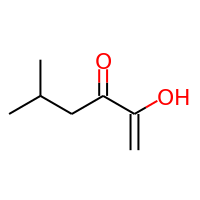
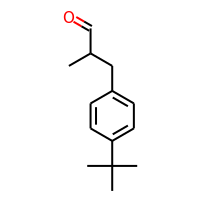
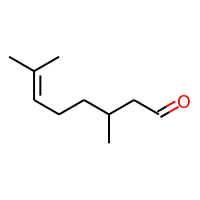
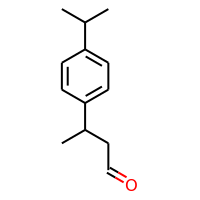
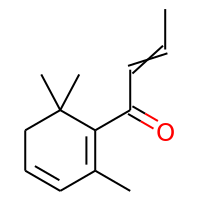
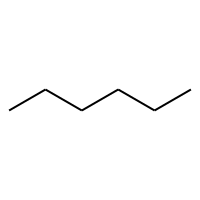
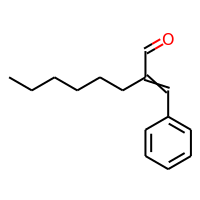
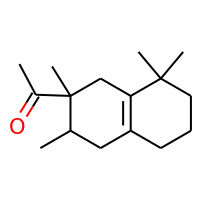
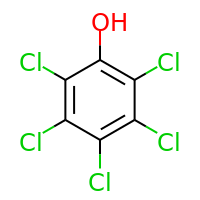
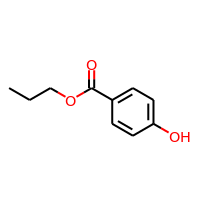
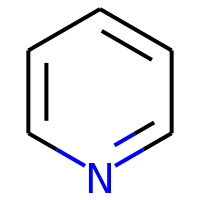
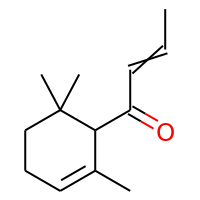
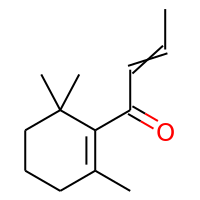
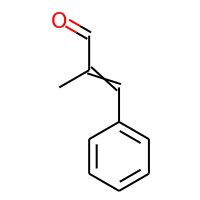

In [48]:
print ("3 individual model's predictions are saying Sensitizer, but the Bayesian decision is Non-sensitizer:",
       sum((moldf['Preds Sum'] >= 3) & (moldf['Bayesian Pred']== 'Non-sensitizer' )))
moldf[(moldf['Preds Sum'] >= 3) & (moldf['Bayesian Pred']== 'Non-sensitizer' )]